===== constraints: =====
Room assignment: "Approaches and Challenges for Across-Site Harmonization of Structural, Functional, and Diffusion MRI" in "Room 4"

===== statistics: =====
  - Stats           : 19062468
  - wall time       : 116.348912 s


===== Schedule: =====
Day1_morning
Room 3: Heterogeneity in Neurodevelopmental Disorders: Identification, Nosology, and Intervention
Room 1: Neuropsychiatric genetic variation shapes brain architecture by modulating gene expression
Room 4: Approaches and Challenges for Across-Site Harmonization of Structural, Functional, and Diffusion MRI
Room 2: Big Data & Machine Learning Personalize Neuropsychiatric Disorders–Ready for Clinical Translation?

Day1_afternoon
Room 3: A tale of parcels & gradients: individual differences & behavioral associations
Room 2: Multi-view methods for imaging genetics
Room 4: Network control theory: recent advances, current limitations, and future directions

Day2_morning
Room 4: Discerning signal from artifact: Cur

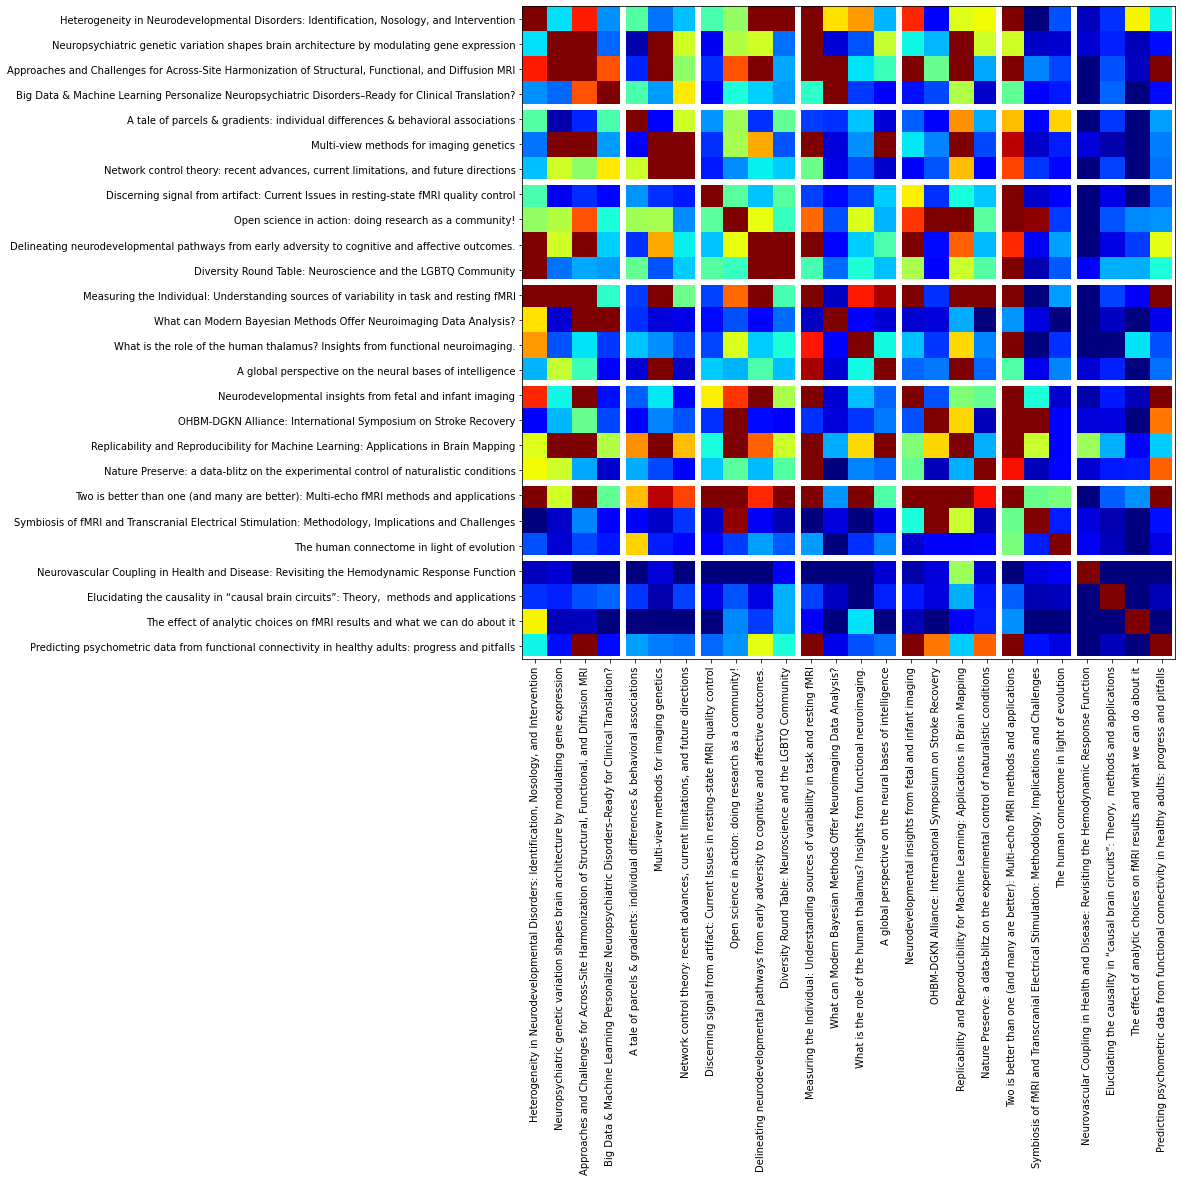

In [148]:
from __future__ import print_function
import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
import itertools
import gspread
from oauth2client.service_account import ServiceAccountCredentials

verbose       = False  # set to True to print extensive output info
verbose_optim = True   # set to True to print running optimization
verbose_plot  = True   # display similarity matrix
save_outputs  = True   # save symposia schedule and (if plotted) similatity matix plot

##################################################################################################
# Load data:
##################################################################################################
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_id.json', scope)
gs = gspread.authorize(creds)

fname = 'https://docs.google.com/spreadsheets/d/1uLQzBNWhVLEJBkFHC_WQf2h0X1YQDuIsov3EDmzWv5A'
sheets = gs.open_by_url(fname)
sheet_names    = ["symposia","symposia_constraints","sessions","rooms","symposia_similarity"]
inputs = {}
for n,i in enumerate(sheet_names):
    inputs[i]  = pd.DataFrame(sheets.get_worksheet(n).get_all_values()[1:], 
                             columns=sheets.get_worksheet(n).get_all_values().pop(0))
names          = inputs['symposia'].Name
panel_titles   = list(names)
timeslotsList  = list(inputs['sessions'].Name)
symp_per_slot  = [int(i) for i in list(inputs['sessions'].Capacity)]
room_names     = list(inputs['rooms'].Name)
rooms          = [int(i) for i in list(inputs['rooms'].Capacity)]
set_priority   = inputs['symposia'].Set_Priority.replace(to_replace="",value=np.nan)
set_session    = inputs['symposia'].Set_Session.replace(to_replace="",value=np.nan)
set_room       = inputs['symposia'].Set_Room.replace(to_replace="",value=np.nan)
avoid_overlap  = inputs['symposia_constraints'].Avoid_overlap.replace(to_replace="",value=np.nan)
ensure_overlap = inputs['symposia_constraints'].Ensure_overlap.replace(to_replace="",value=np.nan)
symposia1      = inputs['symposia_constraints'].Symposia_1.replace(to_replace="",value=np.nan)
symposia2      = inputs['symposia_constraints'].Symposia_2.replace(to_replace="",value=np.nan)

sim_mat_o = np.asarray(inputs['symposia_similarity'].set_index(''))
for n,i in enumerate(sim_mat_o):
    for m,j in enumerate(i):
        sim_mat_o[n,m] = 1. - float(j)
sim_mat = np.zeros((len(sim_mat_o),len(sim_mat_o)),dtype=np.int)
for n,i in enumerate(sim_mat_o * 10000. ):
    for m,j in enumerate(i):
        sim_mat[n,m] = int(j)
        
ns             = len(panel_titles)             # number of symposia
nt             = len(timeslotsList)            # number of time slots
nr             = len(room_names)              # number of rooms

##################################################################################################
# Constraint functions:
##################################################################################################
# add constraints for specific symposia that are already scheduled, eg:
def scheduleSymposia(a,b):
    for j in np.setdiff1d(range(nt),b):
        for r in range(nr):
            m.Add(x[(a,j,r)] == 0) # lock symposium a in list to time slot b
    print('Lock: \"' + panel_titles[a] + '\" to ' + timeslotsList[b])

# prioritize symposia earlier in conference
def prioritizeScheduling(a):
    for c in range(int(nt/2)+1,nt): # put symposium in first half of conference 
        for r in range(nr):
            m.Add(x[(a,c,r)] == 0)
    print('Prioritize: \"' + panel_titles[a] + '\"')
    
# # constrain specific symposia to not be in same time slot, eg:
def avoidSymposiaOverlap(a,b):
    a,b = np.sort([a,b])
    for t in range(nt): 
        m.Add(y[(a,b,t)] == 0)
        m.Add(sum([sum(x[(a,t,r)] for r in range(nr)),sum(x[(b,t,r)] for r in range(nr))]) <= 1)
    print('Don\'t overlap: \"' + panel_titles[a] + '\" with \"' + panel_titles[b] + '\"')
    
# schedule specific symposia together, eg:
def symposiaOverlap(a,b):
    a,b = np.sort([a,b])
    m.Add(sum(y[(a,b,t)] for t in range(nt)) == 1)
    for t1,t2 in list(itertools.combinations(range(nt),2)):
        m.Add(sum([sum(x[(a,t1,r)] for r in range(nr)),sum(x[(b,t2,r)] for r in range(nr))]) <= 1)
        m.Add(sum([sum(x[(a,t2,r)] for r in range(nr)),sum(x[(b,t1,r)] for r in range(nr))]) <= 1)
    print('Schedule together: \"' + panel_titles[a] + '\" and \"' + panel_titles[b] + '\"')

# assign rooms
def assignRooms(a,size):
    # options for size: 'large', 'medium', 'small'
    if size == 'large':
        room_id = np.argmax(rooms)
    if size == 'medium':
        room_id = np.argsort(rooms)[int(len(rooms)/2)]
    if size == 'small':
        room_id = np.argmin(rooms)
    for j in range(nt):
        for i in np.setdiff1d(range(nr),room_id):
            m.Add(x[(a,j,i)] == 0) # assign to largest rooms
    print('Room assignment: \"' + panel_titles[a] + '\" in \"' + room_names[room_id] + '\"')
    
##################################################################################################
# Run optimizer:
##################################################################################################
m = cp_model.CpModel()
x = {}
for s in range(ns):
    for t in range(nt):
        for r in range(nr):
            x[(s,t,r)] = m.NewBoolVar('schedule_s%it%ir%i' % (s,t,r))
for t in range(nt):
    for r in range(nr):
        m.Add(sum(x[(s,t,r)] for s in range(ns)) <= 1)
for s in range(ns):
    m.Add(sum(x[(s,t,r)] for r in range(nr) for t in range(nt)) == 1)
for t in range(nt):
    m.Add(sum(x[(s,t,r)] for s in range(ns) for r in range(nr)) == symp_per_slot[t])

print('===== constraints: =====')
for i in set_room.dropna("").index.values:
    assignRooms(i,set_room.dropna("")[i])
for i in set_session.dropna("").index.values:
    scheduleSymposia(i,inputs['sessions'][inputs['sessions'].Name.str.match(set_session.dropna("")[i])].index.values[0])
for i in set_priority.dropna("").index.values:
    prioritizeScheduling(i)

i_pairs_list = list(itertools.combinations(range(ns),2))
y = {}
for i,ip in i_pairs_list:
    for t in range(nt):
        y[(i,ip,t)] = m.NewBoolVar('overlap_i%iip%it%i' % (i,ip,t))

for i in avoid_overlap.dropna("").index.values:
    avoidSymposiaOverlap(inputs['symposia'][names.str.match(symposia1[i].replace('(','\(').replace(')','\)'))].index.values[0], 
                         inputs['symposia'][names.str.match(symposia2[i].replace('(','\(').replace(')','\)'))].index.values[0])
for i in ensure_overlap.dropna("").index.values:
    symposiaOverlap(inputs['symposia'][names.str.match(symposia1[i].replace('(','\(').replace(')','\)'))].index.values[0], 
                    inputs['symposia'][names.str.match(symposia2[i].replace('(','\(').replace(')','\)'))].index.values[0])

for i,ip in i_pairs_list:
    for j in range(nt):
        m.Add(sum(x[i,t,r] for r in range(nr)) + sum(x[ip,t,r] for r in range(nr)) - y[i,ip,t] <= 1)
        m.Add(2*y[i,ip,t] - sum(x[i,t,r] for r in range(nr)) - sum(x[ip,t,r] for r in range(nr))  <= 0)

m.Maximize(sum(sim_mat[i][ip] * y[(i,ip,t)] for i,ip in i_pairs_list for t in range(nt)))
solver = cp_model.CpSolver()
solver.parameters.linearization_level = 0
solver.Solve(m)

# ##################################################################################################
# # Results:
# ##################################################################################################
# Statistics
print()
print('===== statistics: =====')
print('  - Stats           : %i' % solver.ObjectiveValue())
print('  - wall time       : %f s' % solver.WallTime())
print()

# Schedule
newOrder = []
print()
print("===== Schedule: =====")
file1 = open("schedule.txt","w")
for t in range(nt):
    print('%s' % timeslotsList[t])
    file1.write('%s\n' % timeslotsList[t])
    for s in range(ns):        
        for r in range(nr):
            if solver.Value(x[(s,t,r)]) == 1:
                print('%s: %s' % (room_names[r],panel_titles[s]))
                newOrder.append(s)
                file1.write('%s: %s\n' % (room_names[r],panel_titles[s].encode('utf8').decode("utf-8")))               
    print()
    file1.write('\n')
file1.close()

%matplotlib inline
if verbose_plot:
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    panel_titles_reordered = [panel_titles[i] for i in newOrder]

    fig = plt.figure(figsize=(12,12))
    plt.imshow(sim_mat[:,newOrder][newOrder].squeeze(), interpolation='nearest', cmap=cm.jet_r, vmin=.95*10000.)
    ax = plt.gca()
    ax.set_yticks(np.arange(0, len(panel_titles_reordered), 1))
    ax.set_xticks(np.arange(0, len(panel_titles_reordered), 1))
    ax.set_yticklabels(panel_titles_reordered)
    ax.set_xticklabels(panel_titles_reordered)
    plt.xticks(rotation=90)

    for i in np.cumsum(np.asarray(symp_per_slot))-0.5:
        plt.axvline(x=i, color='white', linewidth=6)
        plt.axhline(y=i, color='white', linewidth=6)

    if save_outputs:
        plt.savefig('symposia_similarity.png')

    plt.show()

    # squares along diagonal reflext similarity of symposia sessions:
